In [1]:
%pylab inline

from ipywidgets import widgets, IntSlider, Label
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


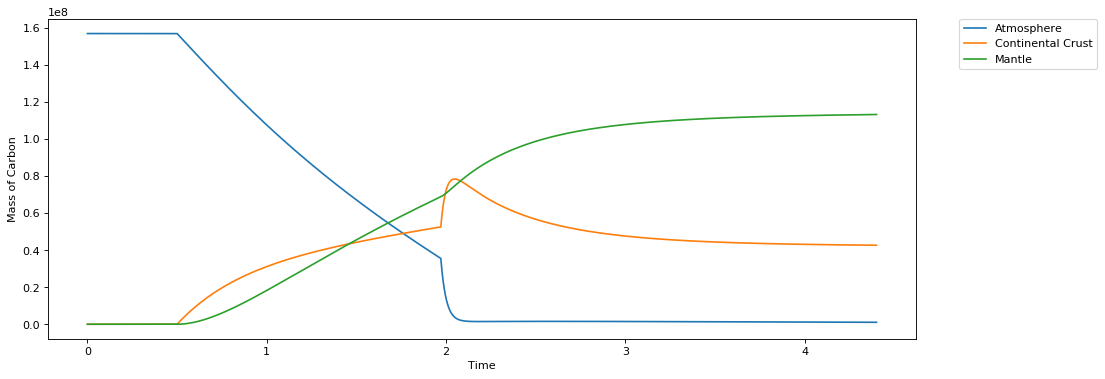

In [49]:
from scipy.integrate import odeint
#help(odeint)    # Uncomment to view the help file for this function

def calc_t_2(cMa0, cMa_2, t_1, tau_1):
    return tau_1 * (-(cMa_2/cMa0) + 1) + t_1

def f(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_2, t_p, tf, tau_1, tau_2, cMa0, cMa_t2, cMmp, cFmap, cMccp, cFccmp = params
    #tau, cMmp, cFmap, cMccp, cFccmp, tp, tf = params
    
    if (t == t_2):
        cMa = cMa_t2
        
    if (t_0 <= t and t < t_1):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - 0,
                  0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    elif (t_1 <= t and t < t_2):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1,
                  cMa0/tau_1 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa/tau_2,
                 cMa/tau_2 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                 ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]

    return derivs

def assemble_solve_ode(cMa0, cMa_t2):
    # Parameters
    t_0 = 0   #Gyr
    t_1 = 0.5 #Gyr
    t_p = 4.4  #Gyr

    tau_1 = 1.5 #Gyr
    #cMa0 = 1.57e8 #Gt
    #cMa_t2 = 5e4 #Gt
    tau_2 = cMa_t2 * (tau_1/cMa0)
    t_2 = calc_t_2(cMa0, cMa_t2, t_1, tau_1) #Gyr
    tf = 3.61
    ts = 1e4

    cFmap = (36/1000)*1e9 #Gt/Gyr
    cMmp = 1.15e8
    cFccmp = (36/1000)*1e9 #Gt/Gyr
    cMccp = 4.2e7

    # Initial values
    #cMa0 = 1.57e8
    cMcc0 = 1.57e8-cMa0
    cMm0 = 0

    # Bundle parameters for ODE solver
    params = [t_0, t_1, t_2, t_p, tf, tau_1, tau_2, cMa0, cMa_t2, cMmp, cFmap, cMccp, cFccmp]
    
    # Bundle initial conditions for ODE solver
    y0 = [cMa0, cMcc0, cMm0]

    t = np.linspace(t_0,t_p,ts)
    solution = odeint(f, y0, t, args=(params,))
    fig = plt.figure(1, figsize=(14,18), dpi= 80, facecolor='w', edgecolor='k')
    #axes = plt.gca()
    #axes.set_yscale('log')

    # Plot cMa as a function of time
    ax1 = fig.add_subplot(311)
    ax1.plot(t, solution[:,0], label='Atmosphere')

    # Plot cMcc as a function of time
    ax2 = fig.add_subplot(311)
    ax2.plot(t, solution[:,1], label='Continental Crust')

    # Plot cMm as a function of time
    ax3 = fig.add_subplot(311)
    ax3.plot(t, solution[:,2], label='Mantle')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Mass of Carbon')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.xlim([2,2.02])
    #plt.ylim([0,1e1])
    plt.show()
    
cMa_t2_widget = widgets.FloatSlider(min=1e0,max=1e8,step=1e2,value=5e4, description="$^cM_{a}(t_2)$", readout_format=".2g")
cMa_t0_widget = widgets.FloatSlider(min=0.42e8,max=1.57e8,step=1e6,value=1.57e8, description="$^cM_{a}(t_0)$", readout_format=".3g")
w = widgets.interactive(assemble_solve_ode,
                        cMa0 = cMa_t0_widget,
                        cMa_t2 = cMa_t2_widget)

display(w)    

For the following case, we assume the $^cF_{a-cc} = 0$ at $0 \le t < t_1$ and that $^cF_{a-cc} = \frac{^cM_{a0}}{\tau_1}$ at $t_1 \le t <= t_p$

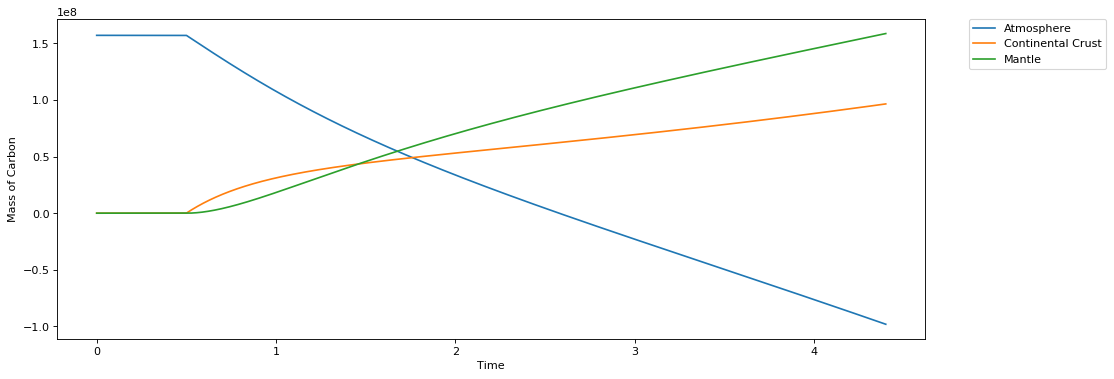

In [48]:
from scipy.integrate import odeint
#help(odeint)    # Uncomment to view the help file for this function

def calc_t_2(cMa0, cMa_2, t_1, tau_1):
    return tau_1 * (-(cMa_2/cMa0) + 1) + t_1

def f(y, t, params):
    cMa, cMcc, cMm = y
    t_0, t_1, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp = params
        
    if (t_0 <= t and t < t_1):
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - 0,
                  0 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]
    else:
        derivs = [(cMm/cMmp)*cFmap*exp((t_p - t)/tf) - cMa0/tau_1,
                  cMa0/tau_1 - (cMcc/cMccp)*cFccmp*exp((t_p - t)/tf),
                  ((cMcc/cMccp)*cFccmp - (cMm/cMmp)*cFmap)*exp((t_p-t)/tf)]

    return derivs

def assemble_solve_ode(tau_1, cMa0):
    # Parameters
    t_0 = 0   #Gyr
    t_1 = 0.5 #Gyr
    t_p = 4.4  #Gyr

    #tau_1 = 1.5 #Gyr
    #cMa0 = 1.57e8 #Gt
    tf = 3.61
    ts = 1e4

    cFmap = (36/1000)*1e9 #Gt/Gyr
    cMmp = 1.15e8
    cFccmp = (36/1000)*1e9 #Gt/Gyr
    cMccp = 4.2e7

    # Initial values
    #cMa0 = 1.57e8
    cMcc0 = 1.57e8-cMa0
    cMm0 = 0

    # Bundle parameters for ODE solver
    params = [t_0, t_1, t_p, tf, tau_1, cMa0, cMmp, cFmap, cMccp, cFccmp]
    
    # Bundle initial conditions for ODE solver
    y0 = [cMa0, cMcc0, cMm0]

    t = np.linspace(t_0,t_p,ts)
    solution = odeint(f, y0, t, args=(params,))
    fig = plt.figure(1, figsize=(14,18), dpi= 80, facecolor='w', edgecolor='k')
    #axes = plt.gca()
    #axes.set_yscale('log')

    # Plot cMa as a function of time
    ax1 = fig.add_subplot(311)
    ax1.plot(t, solution[:,0], label='Atmosphere')

    # Plot cMcc as a function of time
    ax2 = fig.add_subplot(311)
    ax2.plot(t, solution[:,1], label='Continental Crust')

    # Plot cMm as a function of time
    ax3 = fig.add_subplot(311)
    ax3.plot(t, solution[:,2], label='Mantle')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Mass of Carbon')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.xlim([2,2.02])
    #plt.ylim([0,1e1])
    plt.show()
    
tau_1_widget = widgets.FloatSlider(min=1,max=3.0,step=1e-2,value=1.5, description=r'\(\tau_1\)', readout_format=".2g")
cMa_t0_widget = widgets.FloatSlider(min=0.42e8,max=1.57e8,step=1e6,value=1.57e8, description="$^cM_{a}(t_0)$", readout_format=".3g")
w = widgets.interactive(assemble_solve_ode,
                        tau_1 = tau_1_widget,
                        cMa0 = cMa_t0_widget)

display(w)